In [1]:
import sys
sys.path.insert(0, "/home/lars/storage/Documents/FISHscale/")
from importlib import reload  
import pickle
from FISHscale.utils import dataset
from FISHscale.utils.colors import ManyColors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import napari
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from FISHscale.utils import inside_polygon
import colorsys

import napari
from skimage.color import label2rgb
import pandas as pd
import loompy
import zarr
import glob
import json
import math
from scipy.spatial import KDTree


%load_ext autoreload
%autoreload 2

/home/lars/anaconda3/envs/eel2/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/lars/anaconda3/envs/eel2/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/lars/anaconda3/envs/eel2/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


2022-12-08 16:40:18,951 [INFO] WRITING LOG OUTPUT TO /home/lars/.cellpose/run.log


In [21]:
#Download the EEL data from the github page
#Change to your folder
folder = '/home/lars/Share/Dropbox (Linnarsson Group)/Linnarsson Group/Projects/EEL/Data/Human_embryo_5week/annotated/'

#RNA data
fname_970 = folder + 'LBEXP20211113_EEL_HE_5w_970um_RNA_transformed_assigned.parquet'
fname_810 = folder + 'LBEXP20211119_EEL_HE_5w_810um_RNA_transformed_assigned.parquet'
fname_640 = folder + 'LBEXP20211117_EEL_HE_5w_640um_RNA_transformed_assigned.parquet'

In [22]:
#Explicit opening of all 3 datasets instead of using MultiDataset
d970 = dataset.Dataset(fname_970,
                       gene_label = 'decoded_genes', 
                       x_label = 'r_transformed', 
                       y_label = 'c_transformed', 
                       pixel_size='0.27 micrometer', 
                       other_columns=['Tissue', 'Brain'],
                       z = 970,
                       reparse=False,
                      )

d810 = dataset.Dataset(fname_810,  
                       gene_label = 'decoded_genes', 
                       x_label = 'r_transformed', 
                       y_label = 'c_transformed', 
                       pixel_size='0.27 micrometer', 
                       other_columns=['Tissue', 'Brain'], 
                       z = 810,
                       color_input = d970.color_dict,
                
                    
                       reparse=False)

d640 = dataset.Dataset(fname_640,  
                       gene_label = 'decoded_genes', 
                       x_label = 'r_transformed', 
                       y_label = 'c_transformed', 
                       pixel_size='0.27 micrometer', 
                       other_columns=['Tissue', 'Brain'],
                       z = 640,
                       color_input = d970.color_dict,
                       reparse=False)

2022-12-08 16:46:43,454 - INFO -     Loaded: LBEXP20211113_EEL_HE_5w_970um_RNA_transformed_assigned


100%|███████████████████████████████████████████████████████████████████| 448/448 [00:03<00:00, 119.48it/s]


2022-12-08 16:46:52,640 - INFO -     Loaded: LBEXP20211119_EEL_HE_5w_810um_RNA_transformed_assigned


100%|███████████████████████████████████████████████████████████████████| 448/448 [00:02<00:00, 169.68it/s]


2022-12-08 16:46:57,965 - INFO -     Loaded: LBEXP20211117_EEL_HE_5w_640um_RNA_transformed_assigned


2022-12-08 16:48:01,546 - INFO -     Working selection set to: Tissue
2022-12-08 16:48:01,547 - INFO -     Working selection set to: Tissue
2022-12-08 16:48:01,548 - INFO -     Working selection set to: Tissue


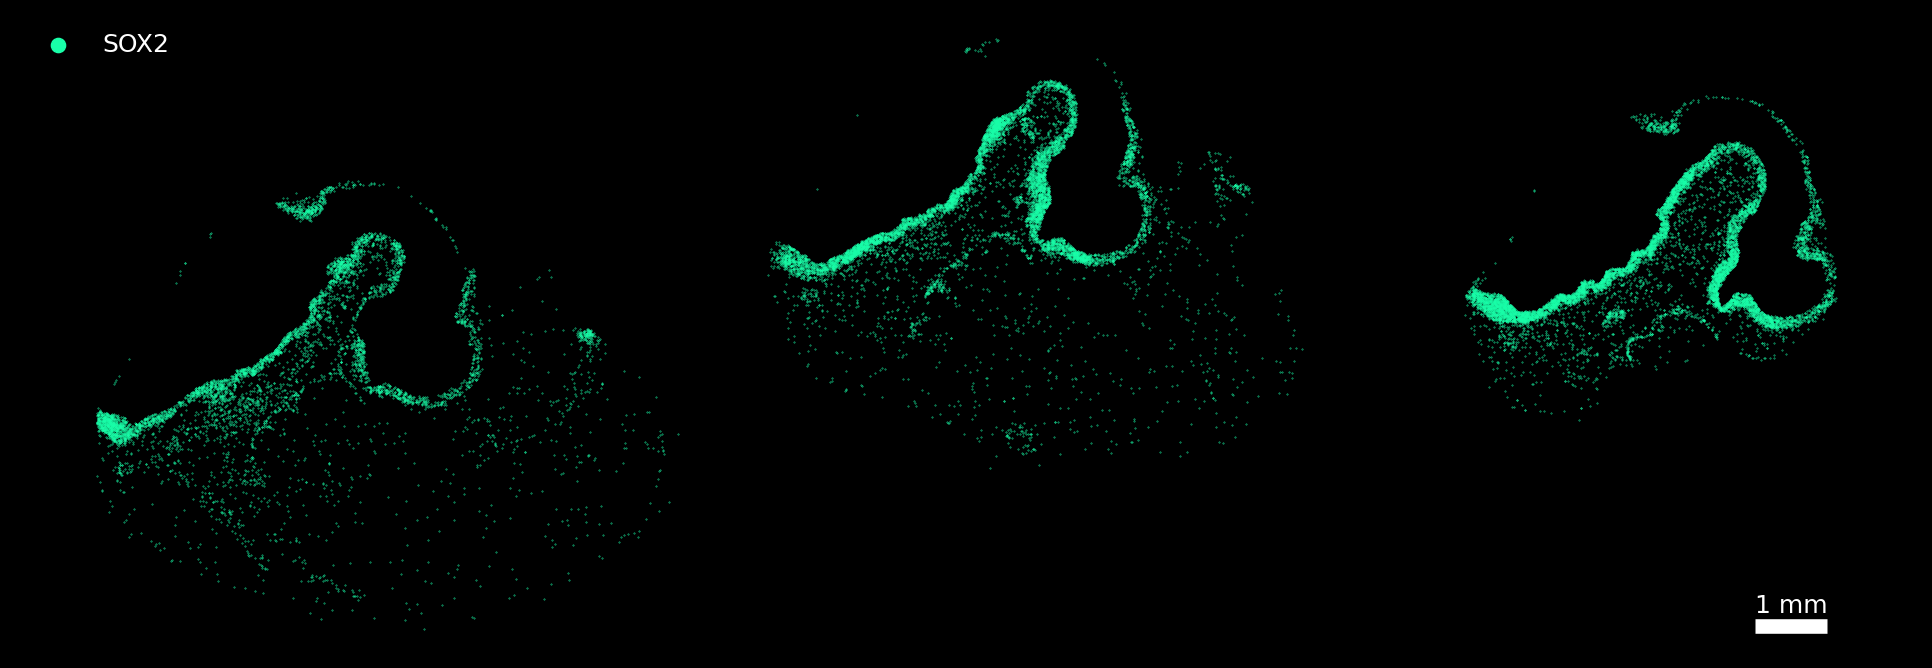

In [26]:
#make FISHscale multidataset
md = dataset.MultiDataset([d970, d810, d640])

#Arange in a grid
md.arange_grid_offset(ncol=3)

#Select only RNA that is in the tissue
md.set_working_selection('Tissue')

#Plot an example
md.scatter_plot('SOX2', ax_scale_factor=20)

2022-12-08 16:48:18,110 - INFO -     Working selection set to: Brain
2022-12-08 16:48:18,111 - INFO -     Working selection set to: Brain
2022-12-08 16:48:18,111 - INFO -     Working selection set to: Brain


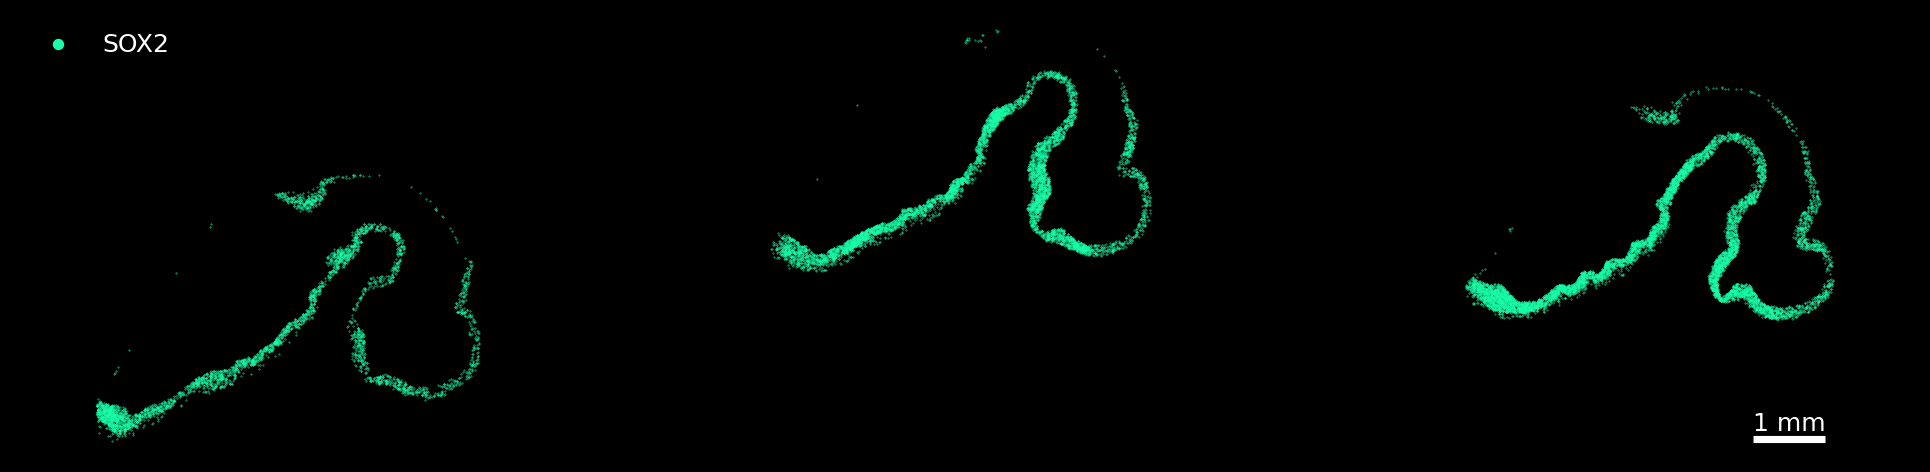

In [27]:
#Select only brain data
md.set_working_selection('Brain')
md.scatter_plot('SOX2', ax_scale_factor=20)

In [28]:
#Make hexagonal bins
hb  = md.hexbin_multi(spacing=50, min_count=10)

[########################################] | 100% Completed | 29.4s


In [29]:
#Merge datasets
df_eel, samples = md.merge_norm(md.get_dict_item(hb, 'df_hex'), mode=None)
hb_size_equal = np.ones(df_eel.shape[1])

split_index = [i.shape[1] for i in md.get_dict_item(hb, 'df_hex')]
split_index = np.cumsum(split_index)[:-1]

3it [00:00, 265.04it/s]


# Load single cell data

In [66]:
#Single cell data
#To replicate select single cells that are 5 weeks old
sc_data = pickle.load(open('HE_single_cell_week5_55_6.pkl', 'rb'))

dataset_name = 'Week5'
selection = False

data = sc_data[dataset_name]
df_sc = data['df']
if selection:
    df_sc = df_sc.loc[gene_list]
volume_sc = data['NCells']
df_metadata = data['metadata']

In [33]:
#Load metadata
folder = '/home/lars/Share/Dropbox (Linnarsson Group)/Linnarsson Group/Projects/EEL/Data/Human_embryo_5week/'
df_metadata_all = pd.read_excel(folder + 'table_S2.xlsx')
df_metadata_all.head(3)

,PoolOrder,PoolCleanOrder,TopLevelOrder,TopLevelCluster,SubCluster,NCells,AutoClass,Class,Subclass,Cycling,...,MeanCellCycleScore,MeanDoubletScore,TopLevelEnriched,SubsetEnriched,PoolEnriched,AutoAnnotation,AutoAnnotationDefs,Location A-P (Week5),Location D-V (Week5),Germinal zone (Week5)
0,0,575,276,14,15,2387,Neuron,Neuron,Neuron,False,...,0.001869,0.163664,"TFAP2D,LHX9,C1QL4,POU4F1,MAB21L1,OBI1-AS1,EBF2...","NRP2,NWD2,GNG8,MMRN1,CPNE4,CDH8,AC093866.1,CRH...","GNG8,NWD2,CPNE9,POU4F1,OBI1-AS1,SNCG,AC093866....",NEUR | NT-VGLUT2,+INA | +SLC17A6,NaN,NaN,NaN
1,1,--,347,17,8,102,Neuroblast,Failed,Failed,False,...,0.001790,0.215119,"HRK,ACTC1,GNG8,NWD2,CPNE9,SHOX2,AL137139.2,COL...","SNCG,NWD2,GPC3,OBI1-AS1,CHRNB3,ONECUT1,PCOLCE2...","NWD2,GNG8,CPNE9,CPNE4,POU4F1,OBI1-AS1,CHRNB3,H...",NBL | NEUR | NT-VGLUT2 | NT-VGLUT3,+NHLH1 | +INA | +SLC17A6 | +SLC17A8,NaN,NaN,NaN
2,2,--,346,17,7,100,Neuroblast,Failed,Failed,False,...,0.001800,0.202511,"HRK,ACTC1,GNG8,NWD2,CPNE9,SHOX2,AL137139.2,COL...","GRIP2,SUSD4,AC135782.1,LINC00290,ADAM11,AC0041...","CPNE9,CPNE4,NWD2,HRK,CNTN2,GNG8,AL137139.2,COL...",NBL | NEUR | NT-VGLUT2,+NHLH1 | +INA | +SLC17A6,NaN,NaN,NaN


In [24]:
filt_failed = np.array([df_metadata_all.loc[i, 'Location A-P (Week5)'] for i in df_sc.columns])
filt_failed = ~np.isin(filt_failed, ['Failed'])

#Select only clusters that were succesfull in previous runs of bonefight (Week5 all or Week5 only Radial Glia clusters)
df_sc_5w = df_sc.loc[:, filt_failed]
volume_sc_5w = volume_sc[filt_failed]

df_sc_5w

,288,431,263,265,266,39,29,271,199,203,...,579,580,561,564,563,584,570,583,581,430
ACTA2,0.003774,0.008889,0.000000,0.000000,0.008333,0.000000,0.006757,0.000000,0.003774,0.008929,...,0.020115,0.020192,0.007194,0.013559,0.019608,0.013957,0.016529,0.024324,0.016260,0.003284
ADARB2,0.022642,0.840000,0.119792,0.258993,0.116667,0.218182,0.790541,2.909722,1.027673,6.258929,...,0.280172,0.277885,0.148201,0.328814,0.153595,0.267969,0.173554,0.762162,0.170732,0.119869
ADGRV1,0.192453,0.640000,0.880208,0.841727,0.358333,0.763636,0.108108,0.340278,0.238994,0.785714,...,3.877874,4.537500,4.181295,1.552542,2.839869,2.665736,0.669421,4.162162,4.882114,2.049261
AIF1,0.000000,0.000000,0.000000,0.007194,0.000000,0.000000,0.000000,0.000000,0.001258,0.000000,...,0.000000,0.000962,0.000000,0.003390,0.000000,0.002094,0.000000,0.001351,0.000000,0.001642
AKAP6,3.652830,1.760000,1.197917,1.294964,3.300000,4.618182,4.027027,3.291667,4.205031,1.982143,...,0.415230,0.149038,1.010072,0.328814,0.627451,0.214236,0.123967,0.098649,0.178862,0.075534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIC1,0.381132,0.995556,0.328125,0.532374,0.066667,0.345455,0.324324,0.034722,0.045283,0.000000,...,0.765805,0.084615,0.033094,0.050847,0.980392,1.057920,5.991736,2.894595,0.093496,1.004926
ZIC2,0.173585,0.035556,0.036458,0.014388,0.000000,0.381818,0.121622,0.006944,0.017610,0.008929,...,0.604885,0.020192,0.005755,0.057627,0.545752,0.217027,1.867769,0.285135,0.052846,0.155993
ZIC4,0.033962,0.053333,0.031250,0.028777,0.000000,0.109091,0.033784,0.020833,0.002516,0.000000,...,0.097701,0.006731,0.004317,0.006780,0.107843,0.133985,1.537190,0.567568,0.016260,0.236453
ZIC5,0.022642,0.000000,0.010417,0.000000,0.008333,0.090909,0.006757,0.000000,0.007547,0.008929,...,0.099138,0.000000,0.002878,0.003390,0.114379,0.041870,0.289256,0.041892,0.012195,0.024631


# Bonefight all succesfull clusters
Elin and Lars manually validated all bonefight mappings. Using either the bonefight mapping for radial glia only to validate the radial glia clusters. Or the Week5 data to validate all non-Radial-Glia clusters. Here these clusters are merged togheter and Bonefight is run on all simultaneously. I think this is the best selection of single cell clusters that are actually present in the spatial EEL data. The reason is that only medial sections were included with EEL. Single cell clusters that are spatially located more laterally will not give accurate results in the mapping, and actually interfer with the mapping of the others. 

100%|███████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.85it/s, loss=-1.2971972]


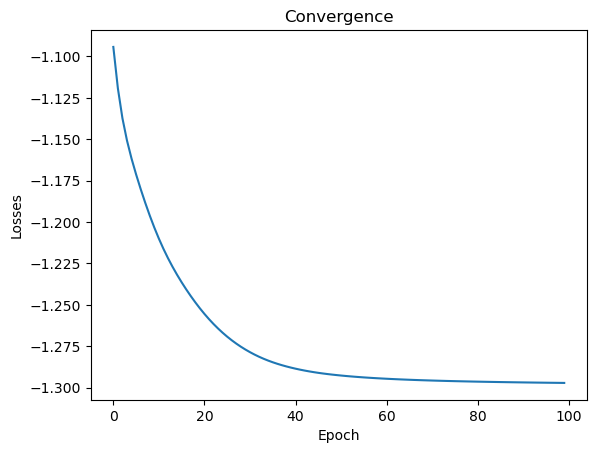

In [36]:
#Run bonefight
model, y = md.bonefight(X_1 = df_sc_5w, volume_1 = volume_sc_5w, 
                     X_2 = df_eel, volume_2 = hb_size_equal, plot=True, transform=True)

#Put results in dataframe
df_bf_5w = pd.DataFrame(y, index=df_eel.columns, columns=df_sc_5w.columns)

In [38]:
def _smooth(xy, data, k=18, weight=True): #k=18
    
    k += 1 #It will find itself but this is later removed
    tree = KDTree(xy)
    dist, kneigh = tree.query(xy, k=k)
    data_np = data.to_numpy()
    #mean = data_np[kneigh[:, 1:]]
    mean = data_np[kneigh[:, :]]
    
    if weight:
        #Weigh by distance
        dist_max = dist.max()
        mean = mean * (dist_max - dist[:,:, np.newaxis])
        
    mean = mean.mean(axis=1)
    

    return mean

In [39]:
#Smooth results
df0_5w = df_bf_5w.iloc[:split_index[0], :]
df1_5w = df_bf_5w.iloc[split_index[0]: split_index[1], :]
df2_5w = df_bf_5w.iloc[split_index[1]:, :]

coord = md.get_dict_item(hb, 'coordinates')

smooth0_5w = _smooth(coord[0], df0_5w)
smooth1_5w = _smooth(coord[1], df1_5w)
smooth2_5w = _smooth(coord[2], df2_5w)

df_smooth_5w = pd.DataFrame(data = np.concatenate((smooth0_5w, smooth1_5w, smooth2_5w), axis=0), index = df_bf_5w.index, columns=df_bf_5w.columns)
df_smooth_5w.shape

(4222, 74)

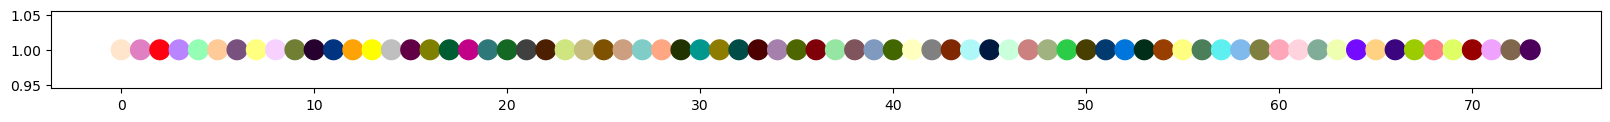

In [40]:
colors75 = np.array([
				[0.9375, 0.63671875, 0.99609375],
				[0., 0.45703125, 0.859375],
				[0.59765625, 0.24609375, 0.],
				[0.296875, 0., 0.359375],
				[0., 0.359375, 0.19140625],
				[0.16796875, 0.8046875, 0.28125],
				[0.99609375, 0.796875, 0.59765625],
				[0.5, 0.5, 0.5],
				[0.578125, 0.99609375, 0.70703125],
				[0.55859375, 0.484375, 0.],
				[0.61328125, 0.796875, 0.],
				[0.7578125, 0., 0.53125],
				[0., 0.19921875, 0.5],
				[0.99609375, 0.640625, 0.01953125],
				[0.99609375, 0.65625, 0.73046875],
				[0.2578125, 0.3984375, 0.],
				[0.99609375, 0., 0.0625],
				[0.3671875, 0.94140625, 0.9453125],
				[0., 0.59765625, 0.55859375],
				[0.875, 0.99609375, 0.3984375],
				[0.453125, 0.0390625, 0.99609375],
				[0.59765625, 0., 0.],
				[0.99609375, 0.99609375, 0.5],
				[0.99609375, 0.99609375, 0.],
				[0.99609375, 0.3125, 0.01953125],
				[0.96875, 0.81835938, 0.99804688],
				[0.5, 0.72851562, 0.9296875],
				[0.79882812, 0.62304688, 0.5],
				[0.6484375, 0.5, 0.6796875],
				[0.5, 0.6796875, 0.59570312],
				[0.58398438, 0.90234375, 0.640625],
				[0.99804688, 0.8984375, 0.79882812],
				[0.75, 0.75, 0.75],
				[0.7890625, 0.99804688, 0.85351562],
				[0.77929688, 0.7421875, 0.5],
				[0.80664062, 0.8984375, 0.5],
				[0.87890625, 0.5, 0.765625],
				[0.5, 0.59960938, 0.75],
				[0.99804688, 0.8203125, 0.50976562],
				[0.99804688, 0.828125, 0.86523438],
				[0.62890625, 0.69921875, 0.5],
				[0.99804688, 0.5, 0.53125],
				[0.68359375, 0.97070312, 0.97265625],
				[0.5, 0.79882812, 0.77929688],
				[0.9375, 0.99804688, 0.69921875],
				[0.7265625, 0.51953125, 0.99804688],
				[0.79882812, 0.5, 0.5],
				[0.99804688, 0.99804688, 0.75],
				[0.99804688, 0.99804688, 0.5],
				[0.99804688, 0.65625, 0.50976562],
				[0.46875, 0.31835938, 0.49804688],
				[0., 0.22851562, 0.4296875],
				[0.29882812, 0.12304688, 0.],
				[0.1484375, 0., 0.1796875],
				[0., 0.1796875, 0.09570312],
				[0.08398438, 0.40234375, 0.140625],
				[0.49804688, 0.3984375, 0.29882812],
				[0.25, 0.25, 0.25],
				[0.2890625, 0.49804688, 0.35351562],
				[0.27929688, 0.2421875, 0.],
				[0.30664062, 0.3984375, 0.],
				[0.37890625, 0., 0.265625],
				[0., 0.09960938, 0.25],
				[0.49804688, 0.3203125, 0.00976562],
				[0.49804688, 0.328125, 0.36523438],
				[0.12890625, 0.19921875, 0.],
				[0.49804688, 0., 0.03125],
				[0.18359375, 0.47070312, 0.47265625],
				[0., 0.29882812, 0.27929688],
				[0.4375, 0.49804688, 0.19921875],
				[0.2265625, 0.01953125, 0.49804688],
				[0.29882812, 0., 0.],
				[0.49804688, 0.49804688, 0.25],
				[0.49804688, 0.49804688, 0.],
				[0.49804688, 0.15625, 0.00976562]])
    
np.random.seed(3)
colors75_r = np.random.permutation(colors75)
color_dict = {clust: col for clust, col in zip(df_bf_5w.columns, colors75_r)}
n_colors = filt_failed.sum()

plt.figure(figsize=(20,1))
x = np.arange(n_colors)
plt.scatter(x, [1]*len(x), c=colors75_r[:n_colors], s=200)

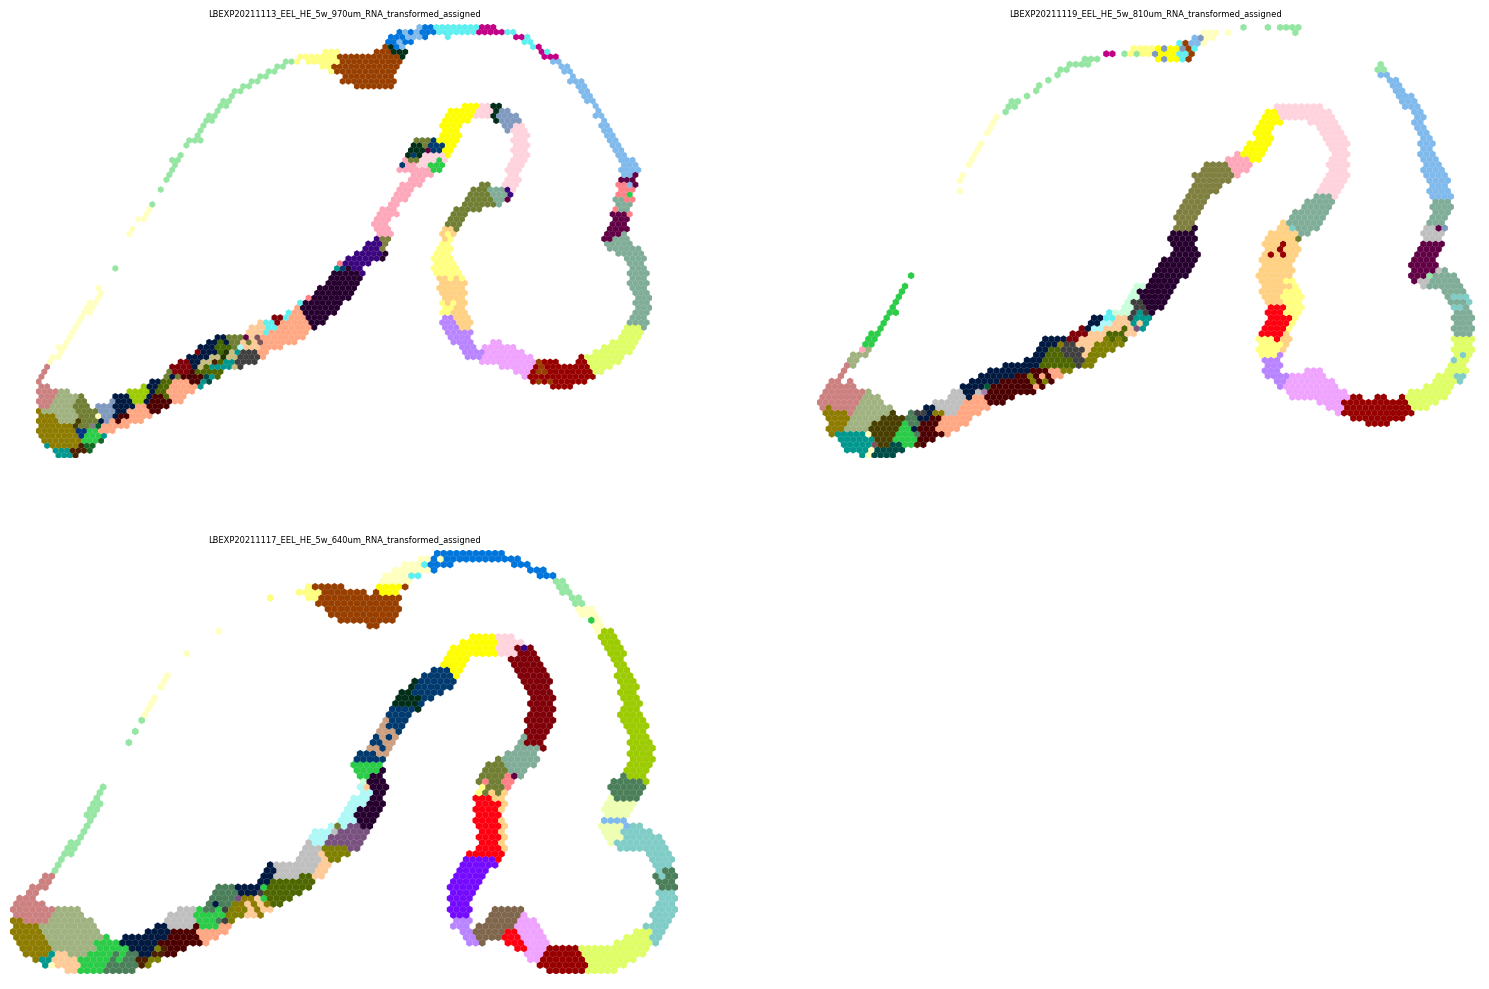

In [42]:
predominant_cluster = df_smooth_5w.columns[np.argmax(df_smooth_5w.to_numpy(), axis=1)]
predominant_cluster_colors = [color_dict[i] for i in predominant_cluster]
predominant_cluster_colors = np.split(predominant_cluster_colors, split_index, axis=0)
predominant_cluster_colors = [list(i) for i in predominant_cluster_colors]

md.hexbin_plot(c=predominant_cluster_colors, figsize=(15,10))

In [ ]:
#Plot raw bonefight results for all clusters
for cluster, n_cells in zip(df_bf_5w.columns, volume_sc) :
    print(f'{cluster}               ', end='\r')
    c = np.split(df_bf_5w.loc[:,cluster].to_numpy(), split_index)
    md.hexbin_plot(c=c, figsize=(15,10)) #df_bf.loc[:,492].to_numpy()
    
    region = df_metadata.loc[cluster, 'CommonestRegion']
    cell_class = df_metadata.loc[cluster, 'Class']
    plt.suptitle(f'Cluster: {cluster}, {region}, {cell_class}, {n_cells} cells')
    plt.savefig(f'Bonefight_hexagons/Week5_selection/{cluster}_all_genes.png', dpi=150, facecolor='white', bbox_inches='tight')
    plt.close()

In [287]:
#Plot smoothed bonefight results for all clusters
for cluster, n_cells in zip(df_smooth_5w.columns, volume_sc) :
    print(f'{cluster}               ', end='\r')
    c = np.split(df_smooth_5w.loc[:,cluster].to_numpy(), split_index)
    md.hexbin_plot(c=c, figsize=(15,10)) #df_bf.loc[:,492].to_numpy()
    
    region = df_metadata.loc[cluster, 'CommonestRegion']
    cell_class = df_metadata.loc[cluster, 'Class']
    plt.suptitle(f'Cluster: {cluster}, {region}, {cell_class}, {n_cells} cells')
    plt.savefig(f'Bonefight_hexagons/Week5_selection_smooth/{cluster}_all_genes.png', dpi=150, facecolor='white', bbox_inches='tight')
    plt.close()

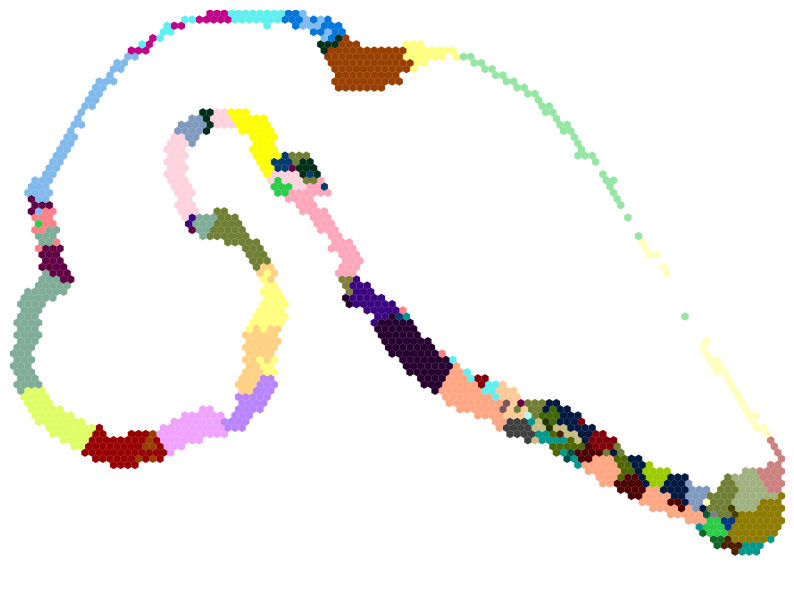

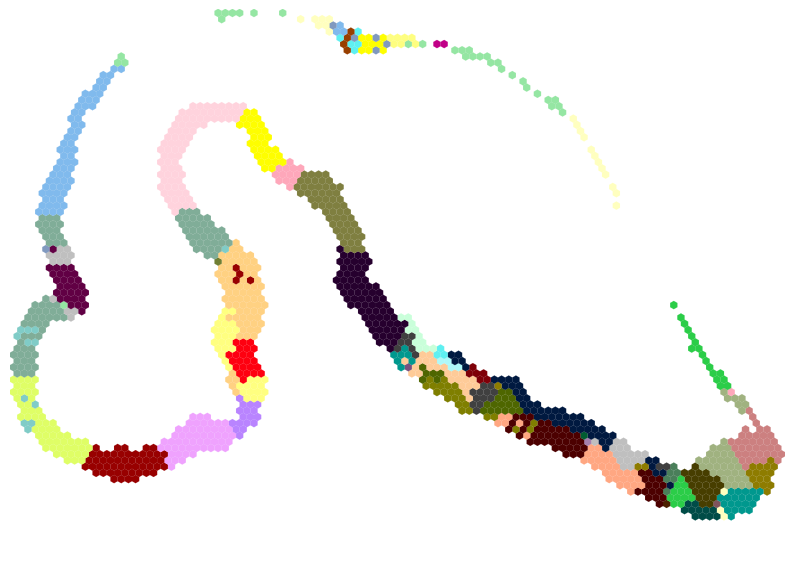

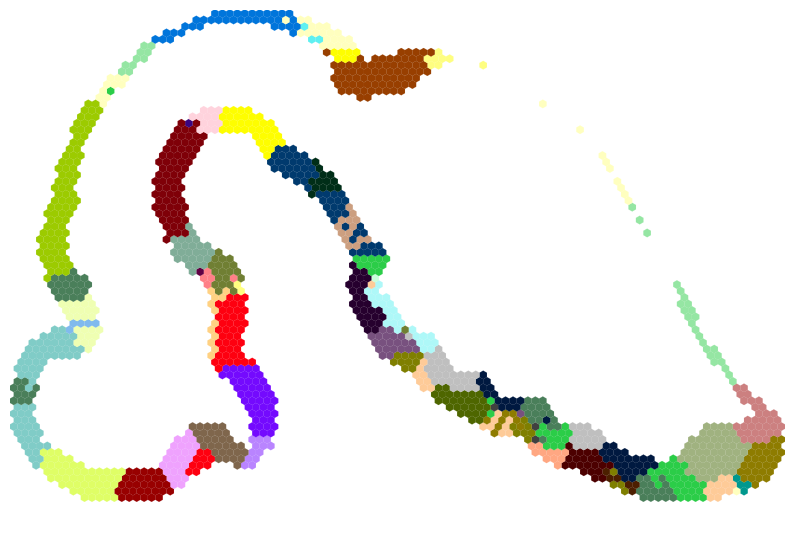

In [43]:
#Plot figures for paper
for i in range(3):
    md.datasets[i].hexbin_plot(predominant_cluster_colors[i])
    plt.gca().invert_xaxis()
    
    ylim = plt.ylim()
    plt.ylim(ylim[0] - 300, ylim[1])
    plt.hlines(ylim[0]-200, 5000, 4500, color='k')
    plt.axis('off')
    #plt.savefig(f'Bonefight_hexagons/Week5_results/{md.datasets[i].dataset_name}_bonefight_mapping_Week5.pdf')

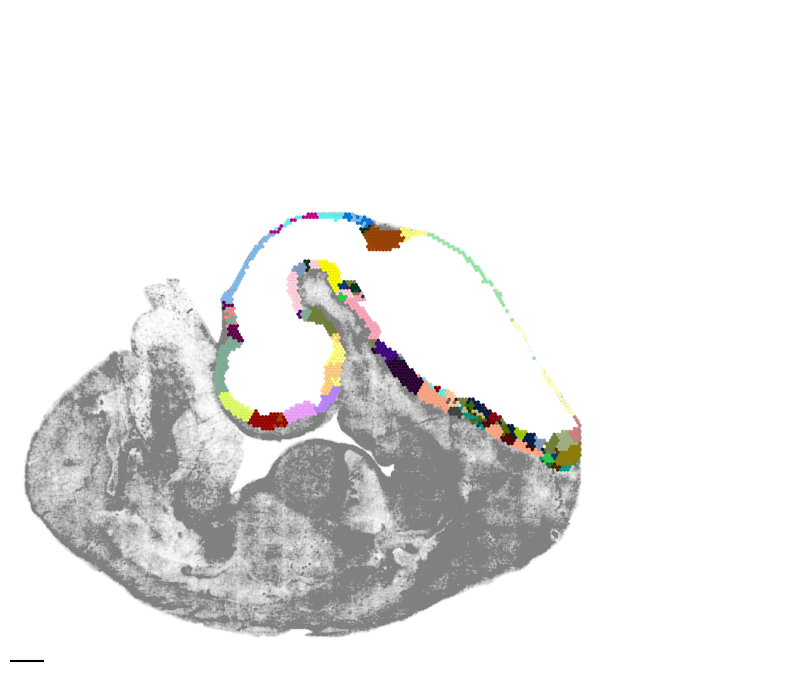

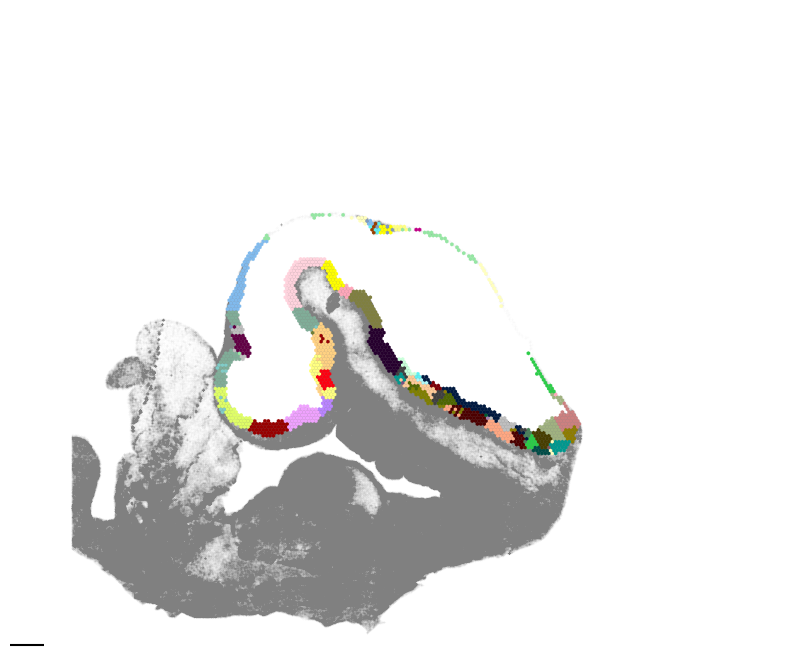

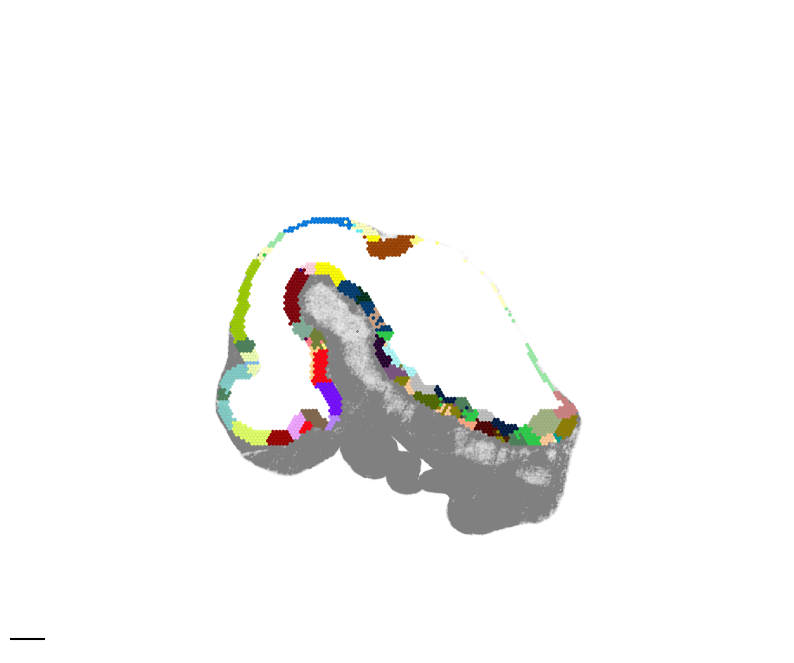

In [67]:
#Plot with RNA in the background
#for i, fn, points in zip(range(3), [fname_970, fname_810, fname_640], [points_970, points_810, points_640]):
for i, fn, d in zip(range(3), [fname_970, fname_810, fname_640], [d970, d810, d640]):
    md.datasets[i].hexbin_plot(predominant_cluster_colors[i])
    plt.gca().invert_xaxis()

    xy = d.df.loc[d.df.loc[:,'Tissue'] == 1, ['x', 'y']].compute()
    xy = xy.to_numpy()
    plt.scatter(xy[:,0], xy[:,1], c='gray', s=0.1, alpha=0.02, zorder=-10)
    
    ymin, ymax = plt.ylim()
    xmin, xmax = plt.xlim()
    extention = 3000
    plt.ylim(ymin-extention, ymax+extention)
    plt.xlim(xmin+extention, xmax-extention)
    
    plt.hlines(ymin-extention+200,  xmin+extention-500,xmin+extention, color='k')
    plt.axis('off')
    
    ax = plt.gca()
    ax.set_rasterization_zorder(-8)
    #plt.savefig(f'Bonefight_hexagons/Week5_results/{md.datasets[i].dataset_name}_RNA.svg', dpi=600)